In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.legacy import Adam
from keras import backend as K
from keras import regularizers
from keras.metrics import AUC
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from tensorflow.keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

from subprocess import check_output

sns.set_style("whitegrid")
np.random.seed(0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [3]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/kaggle/input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comments-dataset-merged/train.csv', sep=',', header=0)
train_df, valid_df = train_df[train_df.index <= 100_000], train_df[train_df.index > 100_000]
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comments-dataset-merged/test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num train: ", valid_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

loading word embeddings...


111052it [00:16, 6899.04it/s]


found 111052 word vectors
num train:  100001
num train:  59570
num test:  153164


In [4]:
y_train = train_df[label_names].values

/tmp/ipykernel_42/3869469920.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['doc_len'], hist=True, kde=True, color='purple', label='doc len')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode

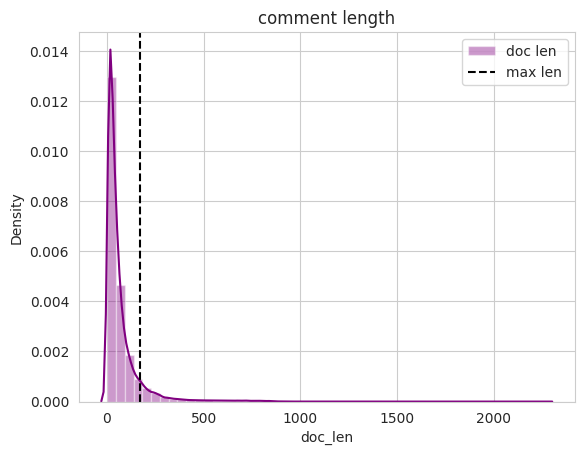

In [7]:
#visualize word distribution
train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='purple', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [49]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_valid = valid_df['comment_text'].tolist() 
raw_docs_test = test_df['comment_text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

processed_docs_valid = []
for doc in tqdm(raw_docs_valid):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_valid.append(" ".join(filtered))
    
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))

pre-processing train data...


100%|██████████| 153164/153164 [00:05<00:00, 29848.00it/s]


In [50]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_valid + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_valid = tokenizer.texts_to_sequences(processed_docs_valid)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
dictionary size:  348520


In [51]:
#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_valid = sequence.pad_sequences(word_seq_valid, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [52]:
#model parameters
batch_size = 256 
num_epochs = 8 

num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [53]:
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 47196
sample words not found:  ['bunchofgrapes' 'hapy' 'kwilu' 'weant' 'sthenelaos' 'everyon' 'mcsim'
 'kodachrome' 'latibeaudiere' 'thấp']


In [54]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', AUC()])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

training CNN ...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 169, 300)          30000000  
                                                                 
 conv1d_4 (Conv1D)           (None, 169, 64)           134464    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 84, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 84, 64)            28736     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 6

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [55]:
hist = model.fit(
    word_seq_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=num_epochs, 
    callbacks=callbacks_list, 
    validation_split=0.1, 
    shuffle=True, 
    verbose=2
)

Epoch 1/8
352/352 - 4s - loss: 0.1075 - accuracy: 0.8108 - auc_2: 0.9061 - val_loss: 0.0659 - val_accuracy: 0.9934 - val_auc_2: 0.9669 - 4s/epoch - 12ms/step
Epoch 2/8
352/352 - 3s - loss: 0.0703 - accuracy: 0.9665 - auc_2: 0.9612 - val_loss: 0.0592 - val_accuracy: 0.9934 - val_auc_2: 0.9733 - 3s/epoch - 9ms/step
Epoch 3/8
352/352 - 3s - loss: 0.0618 - accuracy: 0.9888 - auc_2: 0.9706 - val_loss: 0.0565 - val_accuracy: 0.9934 - val_auc_2: 0.9707 - 3s/epoch - 9ms/step
Epoch 4/8
352/352 - 3s - loss: 0.0563 - accuracy: 0.9913 - auc_2: 0.9760 - val_loss: 0.0632 - val_accuracy: 0.9934 - val_auc_2: 0.9560 - 3s/epoch - 9ms/step
Epoch 5/8
352/352 - 3s - loss: 0.0522 - accuracy: 0.9932 - auc_2: 0.9794 - val_loss: 0.0542 - val_accuracy: 0.9934 - val_auc_2: 0.9744 - 3s/epoch - 9ms/step
Epoch 6/8
352/352 - 3s - loss: 0.0478 - accuracy: 0.9931 - auc_2: 0.9839 - val_loss: 0.0561 - val_accuracy: 0.9934 - val_auc_2: 0.9733 - 3s/epoch - 9ms/step
Epoch 7/8
352/352 - 3s - loss: 0.0440 - accuracy: 0.9934 

In [56]:
# print('Evaluating with Test Data')
# y_test = model.evaluate(word_seq_test, y_test, return_dict=True)
# print(y_test)

In [57]:
te_pred = model.predict(word_seq_test)
te_pred

4787/4787 [==============================] - 7s 2ms/step


array([[9.94517863e-01, 1.98544115e-01, 9.30268288e-01, 5.72891720e-02,
        8.07504535e-01, 1.83940724e-01],
       [1.51460358e-06, 1.02447616e-11, 1.60351732e-07, 1.78126380e-09,
        2.79156289e-08, 1.06242015e-10],
       [1.73391076e-03, 6.24075369e-07, 1.27554435e-04, 1.25456118e-05,
        1.03251565e-04, 3.94116660e-06],
       ...,
       [1.12152309e-03, 7.74708937e-08, 5.58369829e-05, 4.94926917e-06,
        5.02697876e-05, 3.41213126e-06],
       [1.09785888e-03, 1.23397058e-06, 8.08609257e-05, 6.83842518e-05,
        7.96183231e-05, 2.90370190e-05],
       [9.47680473e-01, 7.88204446e-02, 6.67086959e-01, 3.47369015e-02,
        6.23859584e-01, 1.00843556e-01]], dtype=float32)

In [58]:
pd.merge(left=test_df.id.to_frame(), right=pd.DataFrame(te_pred, columns=label_names), left_index=True, right_index=True)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.994518,1.985441e-01,9.302683e-01,5.728917e-02,8.075045e-01,1.839407e-01
1,0000247867823ef7,0.000002,1.024476e-11,1.603517e-07,1.781264e-09,2.791563e-08,1.062420e-10
2,00013b17ad220c46,0.001734,6.240754e-07,1.275544e-04,1.254561e-05,1.032516e-04,3.941167e-06
3,00017563c3f7919a,0.000314,1.665458e-07,6.242405e-05,4.518085e-06,2.854755e-05,8.806051e-07
4,00017695ad8997eb,0.010456,1.416215e-05,8.695446e-04,1.524232e-04,1.008079e-03,7.238634e-05
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.925610,3.830411e-03,4.071393e-01,3.658799e-03,4.144265e-01,1.716314e-02
153160,fffd7a9a6eb32c16,0.001883,2.844272e-07,7.342920e-05,8.615832e-06,8.929125e-05,3.977035e-06
153161,fffda9e8d6fafa9e,0.001122,7.747089e-08,5.583698e-05,4.949269e-06,5.026979e-05,3.412131e-06
153162,fffe8f1340a79fc2,0.001098,1.233971e-06,8.086093e-05,6.838425e-05,7.961832e-05,2.903702e-05


In [59]:
pd.merge(left=test_df.id.to_frame(), right=pd.DataFrame(te_pred, columns=label_names), left_index=True, right_index=True).to_csv('submissions.csv', index=False)

In [60]:
va_pred = model.predict(word_seq_valid)
va_pred

1862/1862 [==============================] - 3s 2ms/step


array([[1.8348710e-03, 1.9430443e-06, 3.0478381e-04, 3.0872070e-05,
        2.3714661e-04, 1.2641692e-05],
       [3.8287585e-04, 6.3566425e-08, 6.3751519e-05, 1.6606148e-06,
        2.3602783e-05, 3.5989854e-07],
       [2.0978984e-03, 2.3387740e-06, 2.3958815e-04, 5.5429005e-05,
        2.3882321e-04, 2.6868951e-05],
       ...,
       [4.1933503e-02, 3.7271879e-05, 3.6406317e-03, 3.6545112e-04,
        4.4385199e-03, 4.1976155e-04],
       [6.1231009e-03, 6.3400876e-06, 5.5289088e-04, 9.1066693e-05,
        6.0202094e-04, 4.6386242e-05],
       [1.9710949e-02, 1.8397885e-05, 1.0841344e-03, 2.1538866e-04,
        1.6398816e-03, 1.5239979e-04]], dtype=float32)

In [61]:
pd.merge(left=valid_df.reset_index().id.to_frame(), right=pd.DataFrame(va_pred, columns=label_names), left_index=True, right_index=True).to_csv('submissions.csv', index=False)

In [62]:
pd.merge(left=valid_df.reset_index().id.to_frame(), right=pd.DataFrame(va_pred, columns=label_names), left_index=True, right_index=True)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,17359f940f219872,0.001835,1.943044e-06,0.000305,3.087207e-05,0.000237,1.264169e-05
1,173693e634e1a6cf,0.000383,6.356643e-08,0.000064,1.660615e-06,0.000024,3.598985e-07
2,17375e3fff2d9d1a,0.002098,2.338774e-06,0.000240,5.542901e-05,0.000239,2.686895e-05
3,173a0ca6d52dd01d,0.000265,3.850002e-08,0.000032,2.251845e-06,0.000018,7.842483e-07
4,173a573b6011f226,0.017438,2.374212e-05,0.001963,2.171399e-04,0.002077,1.255700e-04
...,...,...,...,...,...,...,...
59565,ffe987279560d7ff,0.000078,1.260417e-09,0.000004,1.336512e-07,0.000002,2.989242e-08
59566,ffea4adeee384e90,0.827486,9.801637e-04,0.119894,1.562642e-03,0.175536,6.351702e-03
59567,ffee36eab5c267c9,0.041934,3.727188e-05,0.003641,3.654511e-04,0.004439,4.197615e-04
59568,fff125370e4aaaf3,0.006123,6.340088e-06,0.000553,9.106669e-05,0.000602,4.638624e-05
